In [71]:
import bisect
import time
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

## Preparación del dataset

### Adaptar el dataset

In [72]:
# Cargamos modelo
df = pd.read_csv('../data/data_engineered.csv')

In [73]:
# Eliminamos columnas innecesarias
df = df.drop(columns=['first', 'last', 'city_pop', 'street', 'job', 'dob', 'trans_num', 'hour_window', 'unix_time'])

### Separación de la data 

Dividimos en train y test el dataset

In [74]:
train_mask = (df['trans_month'] == 12) & (df['year'] == 2020)
df_train = df[~train_mask]

df_test = df[((df['trans_month'] == 12) & (df['year'] == 2020))]

Dividimos los train y test con los datos y las respuestas

In [75]:
X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

X_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

Identificamos las variables categoricas

In [76]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

In [77]:
categorical_cols

Index(['merchant', 'category', 'gender', 'city', 'state'], dtype='object')

In [78]:
numerical_cols

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'merch_lat', 'merch_long',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'dist_between_client_and_merch',
       'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant',
       'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month',
       'times_shopped_at_merchant_day', 'time_diff_seconds', 'trans_per_hour',
       'hour_trans_ratio', 'unusual_distance', 'distance_diff',
       'velocity_km_h', 'mean_dist_merchant', 'std_dist_merchant',
       'dist_z_score', 'amt_month_ratio', 'amt_year_ratio',
       'mean_amt_category', 'std_amt_category', 'amt_z_score',
       'high_amt_first_time', 'mean_times_day_merchant',
       'std_times_day_merchant', 'times_day_z_score', 'unique_cards_per_hour',
       'amt_variance_hour'],
      dtype='object')

Copiamos los datasets de datos

In [79]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

Procesamos las variables categoricas

In [80]:
for col in categorical_cols:
    le = LabelEncoder()
    X_train_processed[col] = le.fit_transform(X_train[col].astype(str))

    X_test_processed[col] = X_test[col].astype(str).map(lambda s: '<unknown>' if s not in le.classes_ else s)
    
    if '<unknown>' not in le.classes_:
        if X_test_processed[col].eq('<unknown>').any():
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, '<unknown>')
            le.classes_ = np.array(le_classes)
        
    X_test_processed[col] = le.transform(X_test_processed[col])

## Primer Intento

Definimos los parámetros para nuestro modelo

In [81]:
lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    objective='binary',
    random_state=123,
    n_jobs=2,
    is_unbalance=True
)

Entrenamos el modelo que definimos con la data de entrenamiento

In [82]:
lgbm_classifier.fit(X_train_processed, y_train)

LGBMClassifier(is_unbalance=True, n_jobs=2, objective='binary',
               random_state=123)

Obtenemos las predicciones del modelo entrenado utilizando los datos de prueba

In [83]:
y_pred_lgbm = lgbm_classifier.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test_processed)[:, 1]

In [105]:
print("\nClassification Report:")
report_basic_lgbm = classification_report(y_test, y_pred_lgbm, target_names=['Not Fraud', 'Fraud'], output_dict=True)
print(report_basic_lgbm)

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgbm))

print("\nF1 Score:")
print(f1_score(y_test, y_pred_lgbm, average='weighted'))



Classification Report:
{'Not Fraud': {'precision': 0.9998528427109316, 'recall': 0.9756533601378518, 'f1-score': 0.9876048824625985, 'support': 139280.0}, 'Fraud': {'precision': 0.06558280518049049, 'recall': 0.9224806201550387, 'f1-score': 0.12245948031901209, 'support': 258.0}, 'accuracy': 0.9755550459373074, 'macro avg': {'precision': 0.532717823945711, 'recall': 0.9490669901464452, 'f1-score': 0.5550321813908052, 'support': 139538.0}, 'weighted avg': {'precision': 0.9981254159907346, 'recall': 0.9755550459373074, 'f1-score': 0.9860052643388397, 'support': 139538.0}}

ROC AUC Score:
0.9713363633125398

F1 Score:
0.9860052643388397


In [86]:
print("\nFeature Importances (LightGBM):")
importances = lgbm_classifier.feature_importances_
feature_names = X_train_processed.columns
sorted_indices = np.argsort(importances)[::-1]

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature Importances (LightGBM):
amt: 311
amt_z_score: 305
hour_trans_ratio: 191
mean_times_day_merchant: 176
std_times_day_merchant: 156
amt_month_shopping_net_spend: 155
amt_month_ratio: 150
amt_year_ratio: 145
amt_year: 135
amt_month: 113
hour: 112
time_diff_seconds: 110
times_day_z_score: 70
velocity_km_h: 57
city: 53
cc_num: 48
category: 47
std_dist_merchant: 46
mean_dist_merchant: 45
merchant: 45
times_shopped_at_merchant: 44
mean_amt_category: 41
count_month_shopping_net: 39
distance_diff: 35
merch_lat: 35
dist_between_client_and_merch: 32
dist_z_score: 30
state: 30
zip: 30
lat: 29
trans_per_hour: 26
trans_month: 25
long: 21
std_amt_category: 21
times_shopped_at_merchant_year: 17
merch_long: 16
amt_variance_hour: 15
times_shopped_at_merchant_day: 12
trans_day: 10
year: 6
gender: 5
times_shopped_at_merchant_month: 5
unique_cards_per_hour: 3
high_amt_first_time: 2
first_time_at_merchant: 1
unusual_distance: 0


Imprimimos las features más importantes dentro de las predicciones del modelo

## Métricas Personalizadas

Crear datasets de LightGBM

In [87]:
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)

### Métrica usando cantidad de tarjetas y varianza en la cantidad por hora

In [88]:
def custom_unique_card_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad al detectar si se realiza un ataque coordinado, 
    identificando si se usaron muchas tarjetas diferentes en un periodo corto de tiempo.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
         # Acceder a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        unique_cards = data_to_use['unique_cards_per_hour'].values
        amt_variance = data_to_use['amt_variance_hour'].values
        
        # Identificar posibles ataques coordinados, al identificar si se usaron 
        # muchas tarjetas únicas en un periodo muy corto de tiempo.
        potential_coordinated_attacks = (unique_cards > unique_cards.mean() + 2*unique_cards.std()) | \
                                       (amt_variance < amt_variance.mean() - 2*amt_variance.std())
        
        # Calcular métricas específicas para ataques coordinados
        true_pos_coord = np.sum((labels == 1) & (preds_binary == 1) & potential_coordinated_attacks)
        false_neg_coord = np.sum((labels == 1) & (preds_binary == 0) & potential_coordinated_attacks)
        
        # Penalizar fuertemente los falsos negativos en ataques coordinados
        if true_pos_coord + false_neg_coord > 0:
            coordinated_recall = true_pos_coord / (true_pos_coord + false_neg_coord)
        else:
            coordinated_recall = 1.0  # No hay casos de ataques coordinados
            
        # Métrica general (ponderamos más los errores en ataques coordinados)
        error = np.mean(preds_binary != labels)
        weighted_error = error * 0.3 + (1 - coordinated_recall) * 0.7
        
        return 'unique_card_metric', weighted_error, False
        
    except (ValueError, IndexError):
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives
            
        return 'unique_card_metric', ratio, False  # False porque una tasa menor es mejor

In [89]:
# Configurar parámetros
params_unique_card = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'precision', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.01, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.8, # Definimos la regularización L1
    'lambda_l2': 0.5, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'dart', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_unique_card = lgb.train(
    params_unique_card,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_unique_card_metric # Colocamos nuestra función de evaluación personalizada
)

In [90]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_unique_card = model_unique_card.predict(X_test_processed)
# Convertir a clases
y_pred_binary_unique_card = np.where(y_pred_unique_card > 0.5, 1, 0)

# Calcular las métricas
accuracy_unique_card = accuracy_score(y_test, y_pred_binary_unique_card)
auc_unique_card = roc_auc_score(y_test, y_pred_unique_card)

print("\nClassification Report:")
report_unique_card = classification_report(y_test, y_pred_binary_unique_card, target_names=['Not Fraud', 'Fraud'], output_dict=True)
print(report_unique_card)

print(f"Accuracy: {accuracy_unique_card:.4f}")
print(f"ROC AUC Score: {auc_unique_card:.4f}")


Classification Report:
{'Not Fraud': {'precision': 0.9999269475775817, 'recall': 0.9827541642734061, 'f1-score': 0.9912661857999479, 'support': 139280.0}, 'Fraud': {'precision': 0.09358490566037736, 'recall': 0.9612403100775194, 'f1-score': 0.17056396148555708, 'support': 258.0}, 'accuracy': 0.9827143860453783, 'macro avg': {'precision': 0.5467559266189795, 'recall': 0.9719972371754628, 'f1-score': 0.5809150736427524, 'support': 139538.0}, 'weighted avg': {'precision': 0.9982511585680315, 'recall': 0.9827143860453783, 'f1-score': 0.9897487412767849, 'support': 139538.0}}
Accuracy: 0.9827
ROC AUC Score: 0.9952


### Métrica usando la frecuencia de compra a un vendedor

In [92]:
def custom_merchant_frequency_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo
    en la detección de fraudes basados en patrones inusuales de frecuencia
    de compra entre un usuario y un comerciante.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
        # Acceder a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        # Características importantes para analizar frecuencia usuario-vendedor
        first_time = data_to_use['first_time_at_merchant'].values
        high_amt_first = data_to_use['high_amt_first_time'].values
        times_day_z = data_to_use['times_day_z_score'].values
        
        # Identificar transacciones potencialmente sospechosas por frecuencia
        suspicious_frequency = (first_time == 1) | (high_amt_first == 1) | (times_day_z > 2.0)
        
        # Calcular métricas específicas para patrón de frecuencia inusual
        true_pos_freq = np.sum((labels == 1) & (preds_binary == 1) & suspicious_frequency)
        false_neg_freq = np.sum((labels == 1) & (preds_binary == 0) & suspicious_frequency)
        
        # Calcular el recall en transacciones con frecuencia sospechosa
        if true_pos_freq + false_neg_freq > 0:
            frequency_recall = true_pos_freq / (true_pos_freq + false_neg_freq)
        else:
            frequency_recall = 1.0  # No hay casos sospechosos
        
        # Calculamos las métricas generales
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_positives = np.sum((labels == 0) & (preds_binary == 1))
        
        # Calcular precisión para fraudes en general
        if true_positives + false_positives > 0:
            precision = true_positives / (true_positives + false_positives)
        else:
            precision = 0.0
            
        # Métrica combinada: Balance entre precisión general y recall en casos sospechosos
        # Ponderamos más el recall en casos sospechosos por frecuencia (0.7 vs 0.3)
        weighted_score = 0.3 * precision + 0.7 * frequency_recall
        
        # Invertimos el score para que un valor menor sea mejor (para optimización)
        inverted_score = 1.0 - weighted_score
        
        return 'merchant_frequency_metric', inverted_score, False  # False porque un valor menor es mejor
        
    except (ValueError, IndexError):
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives

        return 'merchant_frequency_metric', ratio, False  # Invertimos F1 para que menor sea mejor

In [93]:
# Configurar parámetros
params_merchant_frequency = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'precision', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 42, # Definimos el número de hojas de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.8, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.6, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'gbdt', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_merchant_frequency = lgb.train(
    params_merchant_frequency,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_merchant_frequency_metric
)

In [94]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_merchant_frequency = model_merchant_frequency.predict(X_test_processed)
# Convertir a clases
y_pred_binary_merchant_frequency = np.where(y_pred_merchant_frequency > 0.5, 1, 0)

# Calcular las métricas
accuracy_merchant_frequency = accuracy_score(y_test, y_pred_binary_merchant_frequency)
auc_merchant_frequency = roc_auc_score(y_test, y_pred_merchant_frequency)

print("\nClassification Report:")
report_merchant_frequency = classification_report(y_test, y_pred_binary_merchant_frequency, target_names=['Not Fraud', 'Fraud'], output_dict=True)
print(report_merchant_frequency)

print(f"Accuracy: {accuracy_merchant_frequency:.4f}")
print(f"ROC AUC Score: {auc_merchant_frequency:.4f}")


Classification Report:
{'Not Fraud': {'precision': 0.9999058659966257, 'recall': 0.9914417001723148, 'f1-score': 0.9956557947372027, 'support': 139280.0}, 'Fraud': {'precision': 0.17049408489909534, 'recall': 0.9496124031007752, 'f1-score': 0.2890855457227139, 'support': 258.0}, 'accuracy': 0.9913643595293038, 'macro avg': {'precision': 0.5851999754478605, 'recall': 0.970527051636545, 'f1-score': 0.6423706702299583, 'support': 139538.0}, 'weighted avg': {'precision': 0.998372317862618, 'recall': 0.9913643595293038, 'f1-score': 0.9943493755234707, 'support': 139538.0}}
Accuracy: 0.9914
ROC AUC Score: 0.9924


### Métrica identificando anomalías en distancias

In [96]:
def custom_distance_anomaly_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo
    en la detección de fraudes basados en anomalías de distancia y velocidad.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
        # Accedemos a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        # Características relacionadas con la distancia
        unusual_distance = data_to_use['unusual_distance'].values
        velocity_km_h = data_to_use['velocity_km_h'].values
        dist_z_score = data_to_use['dist_z_score'].values
        
        # Definimos umbrales para identificar anomalías
        velocity_threshold = 300  # km/h (velocidad imposible entre transacciones)
        z_score_threshold = 2.5   # Más de 2.5 desviaciones estándar es muy inusual
        
        # Identificamos transacciones con anomalías de distancia, viendo si la cumple con algunos de los siguientes
        distance_anomalies = (unusual_distance == 1) | \
                             (velocity_km_h > velocity_threshold) | \
                             (np.abs(dist_z_score) > z_score_threshold)
        
        # Calculamos métricas específicas para anomalías de distancia
        true_pos_dist = np.sum((labels == 1) & (preds_binary == 1) & distance_anomalies)
        false_neg_dist = np.sum((labels == 1) & (preds_binary == 0) & distance_anomalies)
        false_pos_dist = np.sum((labels == 0) & (preds_binary == 1) & distance_anomalies)
        
        # Calculamos métricas generales
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_positives = np.sum((labels == 0) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        # Calculamos recall específico para anomalías de distancia
        if true_pos_dist + false_neg_dist > 0:
            distance_recall = true_pos_dist / (true_pos_dist + false_neg_dist)
        else:
            distance_recall = 1.0  # No hay anomalías de distancia con fraude
        
        # Calculamos precisión específica para anomalías de distancia
        if true_pos_dist + false_pos_dist > 0:
            distance_precision = true_pos_dist / (true_pos_dist + false_pos_dist)
        else:
            distance_precision = 1.0  # No hay predicciones positivas para anomalías
        
        # Calculamos recall general
        if true_positives + false_negatives > 0:
            general_recall = true_positives / (true_positives + false_negatives)
        else:
            general_recall = 0.0
            
        # Calculamos precisión general
        if true_positives + false_positives > 0:
            general_precision = true_positives / (true_positives + false_positives)
        else:
            general_precision = 0.0
        
        # Calculamos F1-score para anomalías de distancia
        if distance_precision + distance_recall > 0:
            distance_f1 = 2 * (distance_precision * distance_recall) / (distance_precision + distance_recall)
        else:
            distance_f1 = 0.0
        
        # Métrica combinada: Balance entre métricas generales y específicas de distancia
        # Damos más peso a la detección de anomalías de distancia
        weighted_score = 0.3 * general_precision + 0.2 * general_recall + 0.5 * distance_f1
        
        # Invertimos para que un valor menor sea mejor
        inverted_score = 1.0 - weighted_score
        
        return 'distance_anomaly_metric', inverted_score, False  # False porque un valor menor es mejor
    
    except (ValueError, IndexError, KeyError) as e:
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives
        
        return 'distance_anomaly_metric', ratio, False

In [97]:
# Configurar parámetros
params_distance_anomaly = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'binary_logloss', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.5, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'gbdt', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_distance_anomaly = lgb.train(
    params_distance_anomaly,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_distance_anomaly_metric,
)

In [103]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_distance_anomaly = model_distance_anomaly.predict(X_test_processed)
# Convertir a clases
y_pred_binary_distance_anomaly = np.where(y_pred_distance_anomaly > 0.5, 1, 0)

# Calcular las métricas
accuracy_distance_anomaly = accuracy_score(y_test, y_pred_binary_distance_anomaly)
auc_distance_anomaly = roc_auc_score(y_test, y_pred_distance_anomaly)

print("\nClassification Report:")
report_distance_anomaly = classification_report(y_test, y_pred_binary_distance_anomaly, target_names=['Not Fraud', 'Fraud'], output_dict=True)
print(report_distance_anomaly)

print(f"Accuracy: {accuracy_distance_anomaly:.4f}")
print(f"AUC: {auc_distance_anomaly:.4f}")


Classification Report:
{'Not Fraud': {'precision': 0.9999201138740413, 'recall': 0.9885482481332567, 'f1-score': 0.9942016636820519, 'support': 139280.0}, 'Fraud': {'precision': 0.13409337676438654, 'recall': 0.9573643410852714, 'f1-score': 0.23523809523809525, 'support': 258.0}, 'accuracy': 0.988490590376815, 'macro avg': {'precision': 0.5670067453192139, 'recall': 0.972956294609264, 'f1-score': 0.6147198794600736, 'support': 139538.0}, 'weighted avg': {'precision': 0.9983192359900652, 'recall': 0.988490590376815, 'f1-score': 0.9927983713841935, 'support': 139538.0}}
Accuracy: 0.9885
AUC: 0.9947


## Comparación entre los modelos

### Confusion Matrix

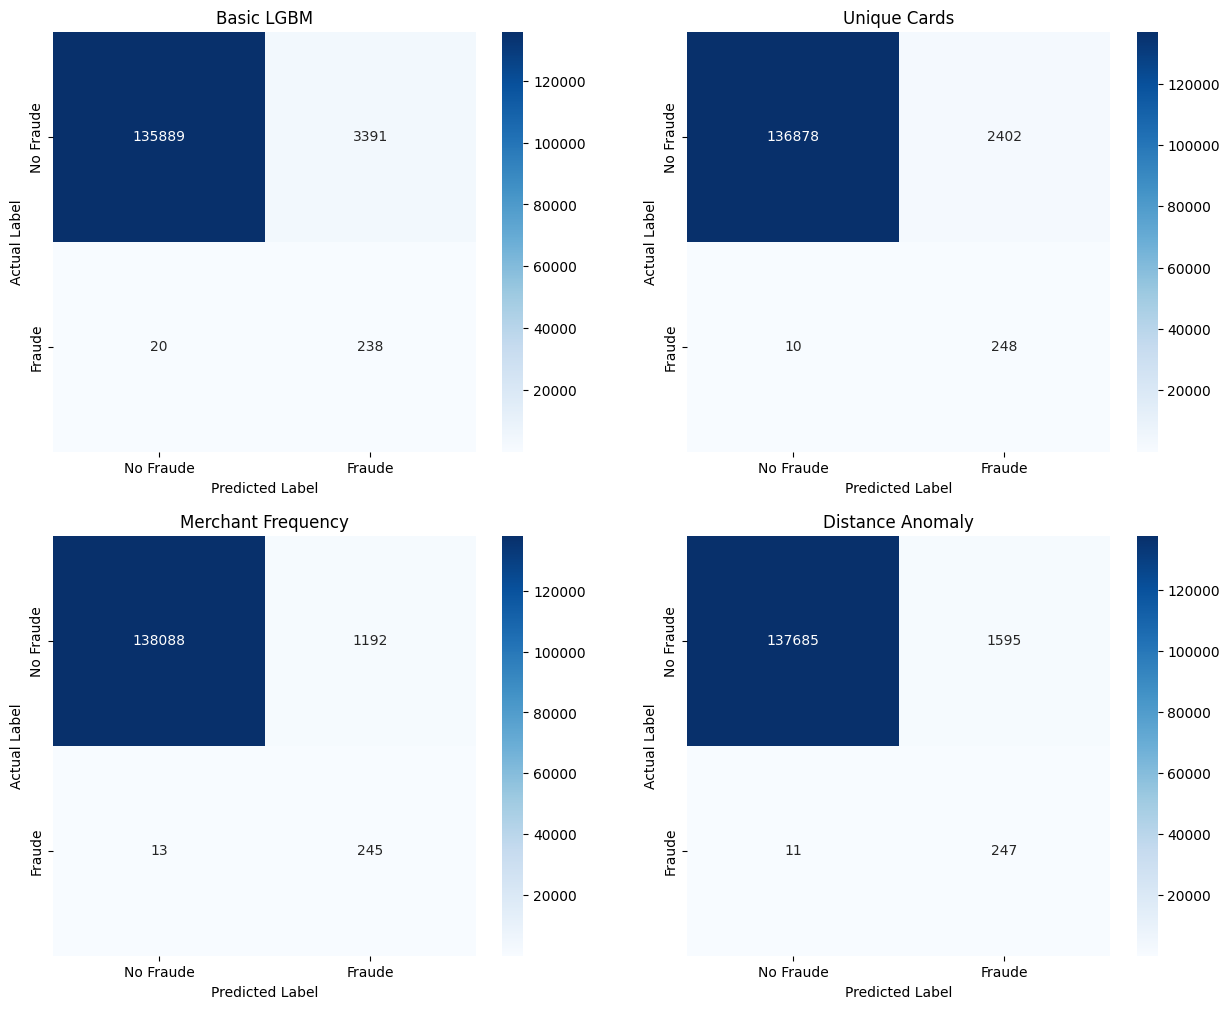

<Figure size 800x600 with 0 Axes>

In [120]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

cm_basic_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_basic_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'], ax=axes[0, 0])
axes[0,0].set_title('Basic LGBM')
axes[0,0].set_ylabel('Actual Label')
axes[0,0].set_xlabel('Predicted Label')

cm_unique_card = confusion_matrix(y_test, y_pred_binary_unique_card)
sns.heatmap(cm_unique_card, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'], ax=axes[0,1])
axes[0,1].set_title('Unique Cards')
axes[0,1].set_ylabel('Actual Label')
axes[0,1].set_xlabel('Predicted Label')

cm_merchant_frequency = confusion_matrix(y_test, y_pred_binary_merchant_frequency)
sns.heatmap(cm_merchant_frequency, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'], ax=axes[1,0])
axes[1,0].set_title('Merchant Frequency')
axes[1,0].set_ylabel('Actual Label')
axes[1,0].set_xlabel('Predicted Label')

cm_distance_anomaly = confusion_matrix(y_test, y_pred_binary_distance_anomaly)
sns.heatmap(cm_distance_anomaly, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], 
            yticklabels=['No Fraude', 'Fraude'], ax=axes[1,1])
axes[1,1].set_title('Distance Anomaly')
axes[1,1].set_ylabel('Actual Label')
axes[1,1].set_xlabel('Predicted Label')

plt.suptitle('Confusion Matrices Comparison', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### ROC-AUC Scores

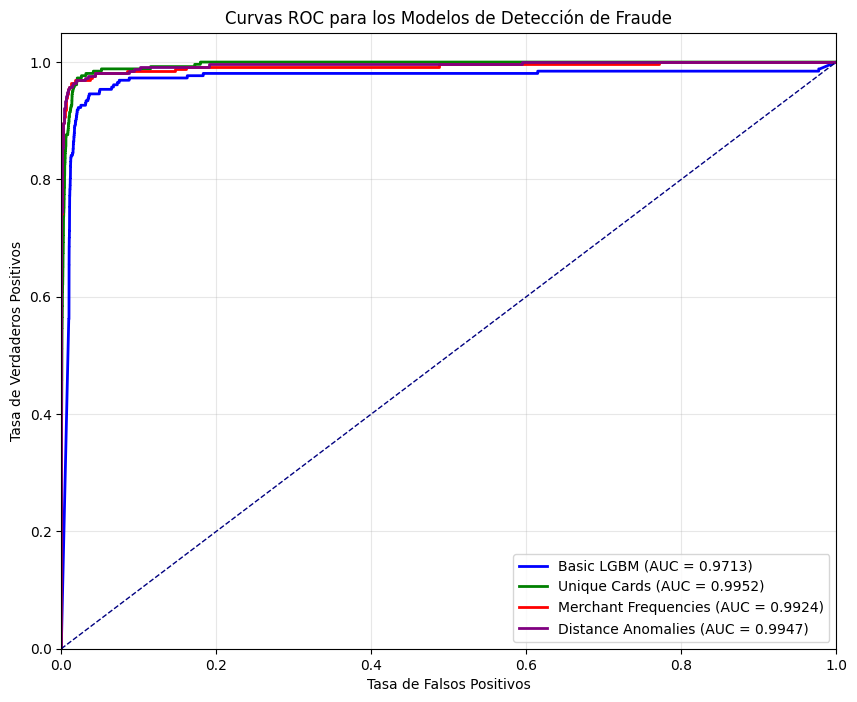

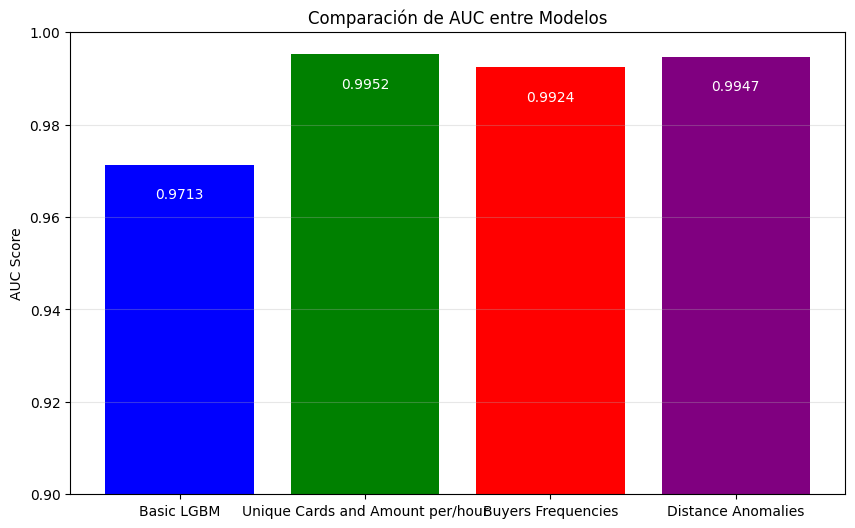

In [100]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_improved, tpr_improved, _ = roc_curve(y_test, y_pred_unique_card)
fpr_fp, tpr_fp, _ = roc_curve(y_test, y_pred_merchant_frequency)
fpr_fn, tpr_fn, _ = roc_curve(y_test, y_pred_distance_anomaly)

roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
roc_auc_improved = roc_auc_score(y_test, y_pred_unique_card)
roc_auc_fp = roc_auc_score(y_test, y_pred_merchant_frequency)
roc_auc_fn = roc_auc_score(y_test, y_pred_distance_anomaly)

plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, 
         label=f'Basic LGBM (AUC = {roc_auc_lgbm:.4f})')
plt.plot(fpr_improved, tpr_improved, color='green', lw=2, 
         label=f'Unique Cards (AUC = {roc_auc_improved:.4f})')
plt.plot(fpr_fp, tpr_fp, color='red', lw=2, 
         label=f'Merchant Frequencies (AUC = {roc_auc_fp:.4f})')
plt.plot(fpr_fn, tpr_fn, color='purple', lw=2, 
         label=f'Distance Anomalies (AUC = {roc_auc_fn:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para los Modelos de Detección de Fraude')

plt.legend(loc='lower right')


plt.grid(True, alpha=0.3)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()


plt.figure(figsize=(10, 6))
models = ['Basic LGBM', 'Unique Cards and Amount per/hour', 'Buyers Frequencies', 'Distance Anomalies']
auc_scores = [roc_auc_lgbm, roc_auc_improved, roc_auc_fp, roc_auc_fn]

bars = plt.bar(models, auc_scores, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.005, 
             f'{height:.4f}', ha='center', va='top', color='white') 

plt.ylim(0.9, 1.0)  
plt.title('Comparación de AUC entre Modelos')
plt.ylabel('AUC Score')
plt.grid(axis='y', alpha=0.3)
plt.show()

### Precision - Accuracy - F1_Score

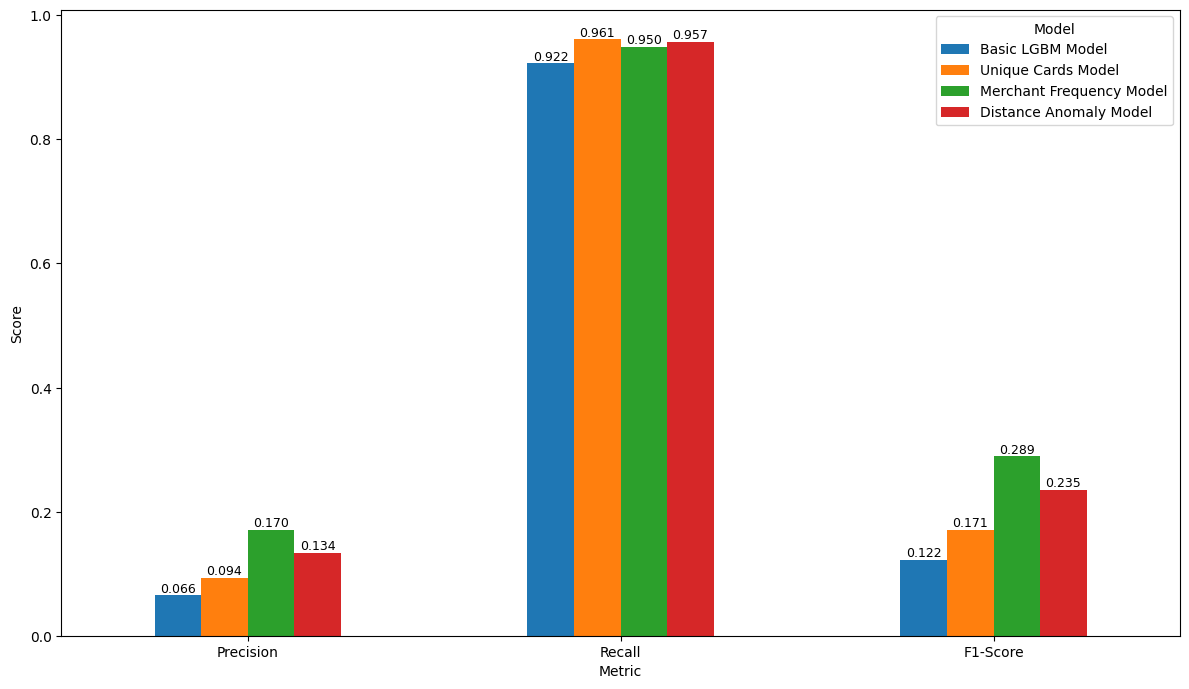

In [111]:
fraud_metric_basic_lgbm = report_basic_lgbm['Fraud']
fraud_metrics_unique_card = report_unique_card['Fraud']
fraud_metrics_merchant_frequency = report_merchant_frequency['Fraud']
fraud_metrics_distance_anomaly = report_distance_anomaly['Fraud']

comparison_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Basic LGBM Model': [
        fraud_metric_basic_lgbm['precision'],
        fraud_metric_basic_lgbm['recall'],
        fraud_metric_basic_lgbm['f1-score']
    ],
    'Unique Cards Model': [
        fraud_metrics_unique_card['precision'],
        fraud_metrics_unique_card['recall'],
        fraud_metrics_unique_card['f1-score']
    ],
    'Merchant Frequency Model': [
        fraud_metrics_merchant_frequency['precision'],
        fraud_metrics_merchant_frequency['recall'],
        fraud_metrics_merchant_frequency['f1-score']
    ],
    'Distance Anomaly Model': [
        fraud_metrics_distance_anomaly['precision'],
        fraud_metrics_distance_anomaly['recall'],
        fraud_metrics_distance_anomaly['f1-score']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

ax = df_comparison.set_index('Metric').plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')

# Agregamos los valores a cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()

In [123]:
print("Best models: Merchant Frequency Model")
for value, index in enumerate(df_comparison['Merchant Frequency Model']):
    print(f"{df_comparison['Metric'][value]}: {index}")

Best models: Merchant Frequency Model
Precision: 0.17049408489909534
Recall: 0.9496124031007752
F1-Score: 0.2890855457227139
